In [13]:
import time
import torch
import sys
import os
import matplotlib.pyplot as plt

# Add project root to PYTHONPATH
sys.path.append('/home/vkapil/scratch/nl/torch-nlpp')

from ase import Atoms
from neighbourlist import NeighbourList
from vesin import ase_neighbor_list
from vesin import NeighborList as NeighbourList_vesin
from torch_nl import compute_neighborlist, ase2data

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [15]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    # warmup
    fn()
    
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

    start = time.perf_counter()
    for _ in range(n_tries):
        fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.perf_counter() - start) / n_tries * 1000.0  # ms

In [16]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
)

In [17]:

supercells = [1, 2, 4, 6, 8, 10]      # (n,n,n) replication
radii = [3.0, 4.5, 6.0]
n_tries = 1

device = "cuda:0" 

In [18]:
results = {}   # radius → num_atoms → timings dict

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n in supercells:

        carbon = base * (n, n, n)
        num_atoms = len(carbon)
        print(f"\nSupercell size: ({n}, {n}, {n})  →  num_atoms = {num_atoms}")

        results[radius][num_atoms] = {}

        # --- VK NeighbourList setup ---
        nl = NeighbourList(
            list_of_configurations=[carbon],
            radius=radius,
            batch_size=1,
            device=device,
        )
        nl.load_data()

        # --- VK NeighbourList ON2 (O(N^2), no compile) ---
        def vk_nl_on2():
            _ = nl.calculate_neighbourlist(use_torch_compile=False)

        t_vk_on2_no_compile = time_fn(vk_nl_on2, n_tries=n_tries, sync_cuda=True)
        results[radius][num_atoms]["vk_on2"] = t_vk_on2_no_compile

        # --- VK NeighbourList ON2 (O(N^2), compile=True) ---
        def vk_nl_on2_compile():
            _ = nl.calculate_neighbourlist(use_torch_compile=True)

        t_vk_on2_compile = time_fn(vk_nl_on2_compile, n_tries=n_tries, sync_cuda=True)
        results[radius][num_atoms]["vk_on2_compile"] = t_vk_on2_compile

        # --- ASE neighbour list (O(N)) ---
        def ase_nl():
            i, j, S, d = ase_neighbor_list("ijSd", carbon, cutoff=radius)

        t_ase = time_fn(ase_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["ase"] = t_ase

        # --- vesin neighbour list (O(N)) ---
        def vesin_nl():
            calculator = NeighbourList_vesin(cutoff=radius, full_list=True)
            i, j, S, d = calculator.compute(
                points=carbon.positions,
                box=carbon.cell,
                periodic=True,
                quantities="ijSd",
            )

        t_vesin = time_fn(vesin_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["vesin"] = t_vesin

        # --- torch-nl O(N) ---
        pos, cell_t, pbc, batch, _ = ase2data([carbon])

        def torch_nl():
            compute_neighborlist(radius, pos, cell_t, pbc, batch, False)

        t_torch_n1 = time_fn(torch_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["torch_n1"] = t_torch_n1

        # print summary for immediate visibility
        print(f"  VK ON2 O(N^2) (no compile) : {t_vk_on2_no_compile:8.3f} ms")
        print(f"  VK ON2 O(N^2) (compile)    : {t_vk_on2_compile:8.3f} ms")
        print(f"  ASE O(N)                   : {t_ase:8.3f} ms")
        print(f"  vesin O(N)                 : {t_vesin:8.3f} ms")
        print(f"  torch-nl O(N)            : {t_torch_n1:8.3f} ms")



radius = 3.0

Supercell size: (1, 1, 1)  →  num_atoms = 4
  VK ON2 O(N^2) (no compile) :    0.990 ms
  VK ON2 O(N^2) (compile)    :    1.157 ms
  ASE O(N)                   :    0.062 ms
  vesin O(N)                 :    0.043 ms
  torch-nl O(N)            :    0.986 ms

Supercell size: (2, 2, 2)  →  num_atoms = 32
  VK ON2 O(N^2) (no compile) :    0.668 ms
  VK ON2 O(N^2) (compile)    :    0.716 ms
  ASE O(N)                   :    0.141 ms
  vesin O(N)                 :    0.099 ms
  torch-nl O(N)            :    1.457 ms

Supercell size: (4, 4, 4)  →  num_atoms = 256
  VK ON2 O(N^2) (no compile) :    0.788 ms
  VK ON2 O(N^2) (compile)    :    0.674 ms
  ASE O(N)                   :    0.639 ms
  vesin O(N)                 :    0.398 ms
  torch-nl O(N)            :    4.558 ms

Supercell size: (6, 6, 6)  →  num_atoms = 864
  VK ON2 O(N^2) (no compile) :    2.947 ms
  VK ON2 O(N^2) (compile)    :    0.932 ms
  ASE O(N)                   :    1.653 ms
  vesin O(N)                 :   

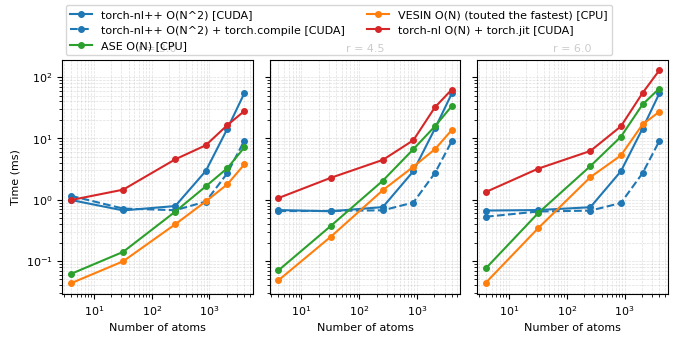

In [19]:
methods = [
    "vk_on2",
    "vk_on2_compile",
    "ase",
    "vesin",
    "torch_n1",
]

labels = [
    "torch-nl++ O(N^2) [CUDA]",
    "torch-nl++ O(N^2) + torch.compile [CUDA]",
    "ASE O(N) [CPU]",
    "VESIN O(N) (touted the fastest) [CPU]",
    "torch-nl O(N) + torch.jit [CUDA]",
]

# Fewer colors: one per method family
colors = {
    "vk_on2":  "tab:blue",
    "ase":     "tab:green",
    "vesin":   "tab:orange",
    "torch_n1":"tab:red",
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1, num_panels,
    sharex=True, sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    num_atoms_list = sorted(results[radius].keys())

    for method, label in zip(methods, labels):
        times = [results[radius][N][method] for N in num_atoms_list]

        # choose color family
        if method.startswith("vk_on2"):
            color_key = "vk_on2"
        elif method.startswith("vk_on1"):
            color_key = "vk_on1"
        else:
            color_key = method  # ase, vesin, torch_n2

        color = colors[color_key]

        # dashed if compile, solid otherwise
        linestyle = "--" if "compile" in method else "-"

        ax.plot(
            num_atoms_list,
            times,
            marker="o",
            linestyle=linestyle,
            color=color,
            label=label,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of atoms")
axes[0].set_ylabel("Time (ms)")

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc="upper center", ncol=len(methods) // 2)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()